In [1]:
# import the libraries
import torch
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import cv2      # open CV
import pandas as pd
import numpy as np
from torchcam.utils import overlay_mask
from PIL import Image, ImageDraw, ImageFont

# In this notebook, we will show information in the different layers

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))
print( torch. __version__)

Using device cuda
2.1.1


### We choose GoogLeNet as our model, see more: https://paperswithcode.com/method/googlenet

In [3]:
# Define your model
from torchvision.models import squeezenet1_1
from torchvision.models import googlenet
model = googlenet(pretrained=True).eval().to(device)

d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
from torchvision import transforms
# Scale, Crop, Turn Tensor, Normalize
test_transform = transforms.Compose([transforms.Resize(256),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            transforms.Normalize(
                                mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225])
                        ])

In [5]:
# test image
img_path = 'test_img/human_dog.jpg'

In [6]:
# image preprocessing
img_pil = Image.open(img_path)
input_tensor = test_transform(img_pil).unsqueeze(0).to(device)

In [7]:
df = pd.read_csv('imagenet_class_index.csv')
idx_to_labels = {}
idx_to_labels_cn = {}
for idx, row in df.iterrows():
    idx_to_labels[row['ID']] = row['class']
    idx_to_labels_cn[row['ID']] = row['Chinese']

### load CAM algorithm

In [8]:
# Set your CAM extractor
from torchcam.methods import GradCAM
# CAM GradCAM GradCAMpp ISCAM LayerCAM SSCAM ScoreCAM SmoothGradCAMpp XGradCAM

target_layer = [model.inception3a,
                model.inception3b,
                model.inception4a,
                model.inception4b,
                model.inception4c,
                model.inception4d,
                model.inception4e,
                model.inception5a,
                model.inception5b,
                ]

image_results = []

for layer in target_layer:
    cam_extractor = GradCAM(model, layer)
    pred_logits = model(input_tensor) # The output has unnormalized scores.
    # choose top n probabilities
    n = 1
    pred_top_n = torch.topk(pred_logits, n) # returns the k largest elements of the given input tensor long a given dimension.
    pred_ids = pred_top_n[1].detach().cpu().numpy().squeeze().item()
    # calculate confidences
    confs = pred_top_n[0].cpu().detach().numpy().squeeze()
    
    activation_map_raw = cam_extractor(pred_ids, pred_logits)
    activation_map = activation_map_raw[0][0].detach().cpu().numpy()
    result = overlay_mask(img_pil, Image.fromarray(activation_map), alpha=0.7) # overlay a colormapped mask on a background image
    
    # use openCV to load image
    img_bgr = cv2.imread(img_path)

    font_size = 40
    font = ImageFont.truetype("arial.ttf", font_size)

    draw = ImageDraw.Draw(result)
    text_pred = 'Pred Class: {}'.format(idx_to_labels[pred_ids])
    draw.text((50, 100), text_pred, font=font, fill=(255, 0, 0, 1))
    
    image_results.append(result)
    

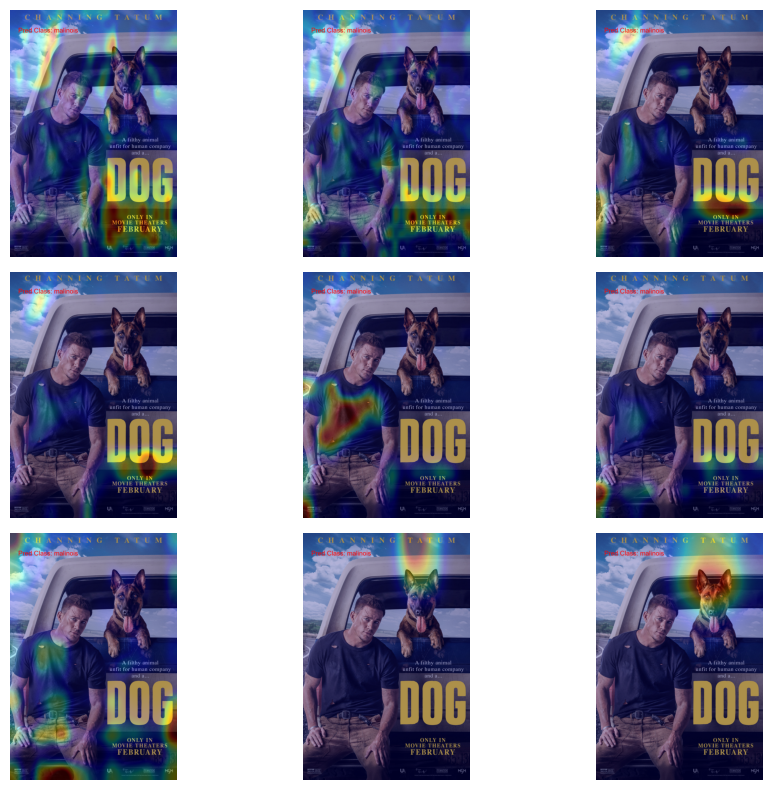

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))

for i in range(3):
    for j in range(3):
        if i * 3 + j < len(image_results):
            index = i * 3 + j
            axes[i, j].imshow(image_results[index], cmap='viridis')
            axes[i, j].axis('off')
            
plt.tight_layout()
plt.show()